<a href="https://colab.research.google.com/github/zq0315/blog/blob/master/colabs/intro/Intro_to_relu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_&_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{intro-colab} -->

<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_&_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{intro-colab} -->

<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{intro-colab} -->

Use [W&B](https://wandb.ai/site?utm_source=intro_colab&utm_medium=code&utm_campaign=intro) for machine learning experiment tracking, model checkpointing, collaboration with your team and more. See the full W&B Documentation [here](https://docs.wandb.ai/).

In this notebook, you will create and track a machine learning experiment using a simple PyTorch model. By the end of the notebook, you will have an interactive project dashboard that you can share and customize with other members of your team. [View an example dashboard here](https://wandb.ai/wandb/wandb_example).

## Prerequisites

Install the W&B Python SDK and log in:

In [ ]:
!pip install wandb -qU

In [ ]:
# Log in to your W&B account
import wandb
import random
import math

In [ ]:
wandb.login()

## Simulate and track a machine learning experiment with W&B

Create, track, and visualize a machine learning experiment. To do this:

1. Initialize a [W&B run](https://docs.wandb.ai/guides/runs) and pass in the hyperparameters you want to track.
2. Within your training loop, log metrics such as the accuruacy and loss.

In [ ]:
import random
import math

# Launch 5 simulated experiments
total_runs = 5
for run in range(total_runs):
  # 1️. Start a new run to track this script
  wandb.init(
      # Set the project where this run will be logged
      project="basic-intro",
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"experiment_{run}",
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.02,
      "architecture": "CNN",
      "dataset": "CIFAR-100",
      "epochs": 10,
      })

  # This simple block simulates a training loop logging metrics
  epochs = 10
  offset = random.random() / 5
  for epoch in range(2, epochs):
      acc = 1 - 2 ** -epoch - random.random() / epoch - offset
      loss = 2 ** -epoch + random.random() / epoch + offset

      # 2️. Log metrics from your script to W&B
      wandb.log({"acc": acc, "loss": loss})

  # Mark the run as finished
  wandb.finish()

View how your machine learning peformed in your W&B project. Copy and paste the URL link that is printed from the previous cell. The URL will redirect you to a W&B project that contains a dashboard showing graphs the show how

The following image shows what a dashboard can look like:

![](https://i.imgur.com/Pell4Oo.png)

Now that we know how to integrate W&B into a psuedo machine learning training loop, let's track a machine learning experiment using a basic PyTorch neural network. The following code will also upload model checkpoints to W&B that you can then share with other teams in in your organization.

##  Track a machine learning experiment using Pytorch

The following code cell defines and trains a simple MNIST classifier. During training, you will see W&B prints out URLs. Click on the project page link to see your results stream in live to a W&B project.

W&B runs automatically log [metrics](https://docs.wandb.ai/ref/app/pages/run-page#charts-tab),
[system information](https://docs.wandb.ai/ref/app/pages/run-page#system-tab),
[hyperparameters](https://docs.wandb.ai/ref/app/pages/run-page#overview-tab),
[terminal output](https://docs.wandb.ai/ref/app/pages/run-page#logs-tab) and
you'll see an [interactive table](https://docs.wandb.ai/guides/data-vis)
with model inputs and outputs.

### Set up PyTorch Dataloader
The following cell defines some useful functions that we will need to train our machine learning model. The functions themselves are not unique to W&B so we'll not cover them in detail here. See the PyTorch documentation for more information on how to define [forward and backward training loop](https://pytorch.org/tutorials/beginner/nn_tutorial.html), how to use [PyTorch DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) to load data in for training, and how define PyTorch models using the [`torch.nn.Sequential` Class](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

In [ ]:
#@title
import torch, torchvision
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T

MNIST.mirrors = [mirror for mirror in MNIST.mirrors if "http://yann.lecun.com/" not in mirror]

device = "cuda:0" if torch.cuda.is_available() else "cpu"

def get_dataloader(is_train, batch_size, slice=5):
    "Get a training dataloader"
    full_dataset = MNIST(root=".", train=is_train, transform=T.ToTensor(), download=True)
    sub_dataset = torch.utils.data.Subset(full_dataset, indices=range(0, len(full_dataset), slice))
    loader = torch.utils.data.DataLoader(dataset=sub_dataset,
                                         batch_size=batch_size,
                                         shuffle=True if is_train else False,
                                         pin_memory=True, num_workers=2)
    return loader

def get_model(dropout):
    "A simple model"
    model = nn.Sequential(nn.Flatten(),
                         nn.Linear(28*28, 256),
                         nn.BatchNorm1d(256),
                         nn.ReLU(),
                         nn.Dropout(dropout),
                         nn.Linear(256,10)).to(device)
    return model

def validate_model(model, valid_dl, loss_func, log_images=False, batch_idx=0):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(device), labels.to(device)

            # Forward pass ➡
            outputs = model(images)
            val_loss += loss_func(outputs, labels)*labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Log one batch of images to the dashboard, always same batch_idx.
            if i==batch_idx and log_images:
                log_image_table(images, predicted, labels, outputs.softmax(dim=1))
    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)

### Create a teble to compare the predicted values versus the true value

The following cell is unique to W&B, so let's go over it.

In the cell we define a function called `log_image_table`. Though technically, optional, this function creates a W&B Table object. We will use the table object to create a table that shows what the model predicted for each image.

More specifically, each row will conists of the image fed to the model, along with predicted value and the actual value (label).

In [ ]:
def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

### Train your model and upload checkpoints

The following code trains and saves model checkpoints to your project. Use model checkpoints like you normally would to assess how the model performed during training.

W&B also makes it easy to share your saved models and model checkpoints with other members of your team or organization. To learn how to share your model and model checkpoints with members outside of your team, see [W&B Registry](https://docs.wandb.ai/guides/registry).

In [ ]:
# Launch 3 experiments, trying different dropout rates
for _ in range(3):
    # initialise a wandb run
    wandb.init(
        project="pytorch-intro",
        config={
            "epochs": 5,
            "batch_size": 128,
            "lr": 1e-3,
            "dropout": random.uniform(0.01, 0.80),
            })

    # Copy your config
    config = wandb.config

    # Get the data
    train_dl = get_dataloader(is_train=True, batch_size=config.batch_size)
    valid_dl = get_dataloader(is_train=False, batch_size=2*config.batch_size)
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # A simple MLP model
    model = get_model(config.dropout)

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

   # Training
    example_ct = 0
    step_ct = 0
    for epoch in range(config.epochs):
        model.train()
        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            example_ct += len(images)
            metrics = {"train/train_loss": train_loss,
                       "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
                       "train/example_ct": example_ct}

            if step + 1 < n_steps_per_epoch:
                # Log train metrics to wandb
                wandb.log(metrics)

            step_ct += 1

        val_loss, accuracy = validate_model(model, valid_dl, loss_func, log_images=(epoch==(config.epochs-1)))

        # Log train and validation metrics to wandb
        val_metrics = {"val/val_loss": val_loss,
                       "val/val_accuracy": accuracy}
        wandb.log({**metrics, **val_metrics})

        # Save the model checkpoint to wandb
        torch.save(model, "my_model.pt")
        wandb.log_model("./my_model.pt", "my_mnist_model", aliases=[f"epoch-{epoch+1}_dropout-{round(wandb.config.dropout, 4)}"])

        print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")

    # If you had a test set, this is how you could log it as a Summary metric
    wandb.summary['test_accuracy'] = 0.8

    # Close your wandb run
    wandb.finish()

You have now trained your first model using W&B. Click on one of the links above to see your metrics and see your saved model checkpoints in the Artifacts tab in the W&B App UI

## (Optional) Set up a W&B Alert

Create a [W&B Alerts](https://docs.wandb.ai/guides/track/alert) to send alerts to your Slack or email from your Python code.

There are 2 steps to follow the first time you'd like to send a Slack or email alert, triggered from your code:

1) Turn on Alerts in your W&B [User Settings](https://wandb.ai/settings)
2) Add `wandb.alert()` to your code. For example:

```python
wandb.alert(
    title="Low accuracy",
    text=f"Accuracy is below the acceptable threshold"
)
```

The following cell shows a minimal example below to see how to use `wandb.alert`

In [ ]:
# Start a wandb run
wandb.init(project="pytorch-intro")

# Simulating a model training loop
acc_threshold = 0.3
for training_step in range(1000):

    # Generate a random number for accuracy
    accuracy = round(random.random() + random.random(), 3)
    print(f'Accuracy is: {accuracy}, {acc_threshold}')

    # Log accuracy to wandb
    wandb.log({"Accuracy": accuracy})

    # If the accuracy is below the threshold, fire a W&B Alert and stop the run
    if accuracy <= acc_threshold:
        # Send the wandb Alert
        wandb.alert(
            title='Low Accuracy',
            text=f'Accuracy {accuracy} at step {training_step} is below the acceptable theshold, {acc_threshold}',
        )
        print('Alert triggered')
        break

# Mark the run as finished (useful in Jupyter notebooks)
wandb.finish()

You can find the full docs for [W&B Alerts here](https://docs.wandb.ai/guides/track/alert).

## Next steps
The next tutorial you will learn how to do hyperparameter optimization using W&B Sweeps:
[Hyperparameters sweeps using PyTorch](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb)

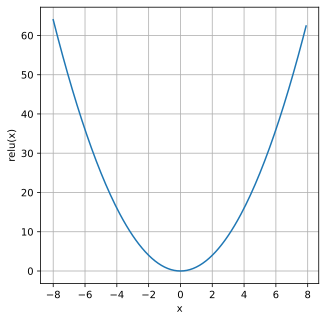

In [15]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 5))

y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))